<a href="https://colab.research.google.com/github/gsanc018/Forecasting/blob/main/4_1_Window_20_Clust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install giotto-tda -q
!pip install yfinance -q
!pip install tslearn -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from tslearn.generators import random_walks
from tslearn.generators import random_walk_blobs
from tslearn.metrics import cdist_dtw
from tslearn.clustering import silhouette_score, TimeSeriesKMeans

from gtda.time_series import Labeller
from gtda.time_series import SlidingWindow, TakensEmbedding
from gtda.time_series import PearsonDissimilarity
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude
from gtda.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from functools import partial
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import clone

# his = yf.Ticker("BTC-USD").history(period = '1y', interval='1h')
his = yf.Ticker("BTC-USD").history(period = 'max', interval= '1d')

btc = his.Close.values
btc = btc.reshape(len(btc),1)
print(btc.shape)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 7.4 MB/s eta 0:00:00
(3205, 1)


In [ ]:
SIZE = 20
STRIDE = 1

#Create Sliding Windows
Lab = Labeller(size=SIZE, func=np.std, n_steps_future=1)
SW = SlidingWindow(size=SIZE, stride=STRIDE)
pipe = make_pipeline(Lab, SW)
df,labels = pipe.fit_transform_resample(btc,btc)
print(df.shape)

#Filter
threshold = 0.05
return_windows = np.diff(df,axis=1)/df[:,:-1]
y=df[np.abs(return_windows).max(axis=1)>threshold]
#z = time_windows[np.abs(x).max(axis=1)>threshold]
print(y.shape)

#Scale
TSMM = TimeSeriesScalerMinMax()
yo = TSMM.fit_transform(y).reshape(len(y),y.shape[1])

# Randomly select 1000 samples from yo
indices = np.random.choice(len(yo), size=200, replace=False)
yo_sample = yo[indices]
df = pd.DataFrame(yo_sample)

(3167, 20)
(2482, 20)


#Silhouette

In [ ]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="data",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax-.5,ymax-.04), **kw)


CPU times: user 2.18 s, sys: 18.4 ms, total: 2.2 s
Wall time: 2.2 s


Text(0, 0.5, 'Silhoutte Score')

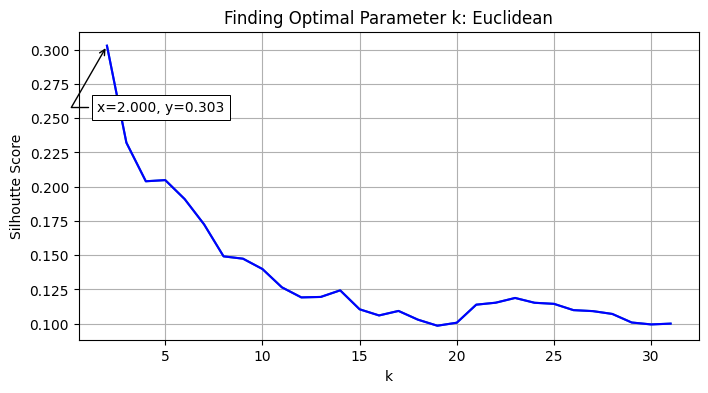

In [ ]:
%%time
ran = 30

sils = []
METRIC = "euclidean"
fig, ax = plt.subplots(figsize=(8, 4))
for k in range(ran):
  km = TimeSeriesKMeans(n_clusters=k+2, metric=METRIC, max_iter=25, random_state=0).fit(df)
  s = silhouette_score(df, km.labels_, metric=METRIC)
  sils.append(pd.DataFrame([k+2,s]).T)

sils = pd.concat(sils, ignore_index=True)
plt.plot(sils[0],sils[1])
sils.iloc[np.argmax(sils[1])][0]

ax.plot(sils[0],sils[1],c='b',ls='-',fillstyle='none')
annot_max(sils[0],sils[1],ax)
plt.grid()
plt.title('Finding Optimal Parameter k: Euclidean')
plt.xlabel("k")
plt.ylabel("Silhoutte Score")


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

CPU times: user 2min 34s, sys: 585 ms, total: 2min 35s
Wall time: 2min 37s


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Text(0, 0.5, 'Silhoutte Score')

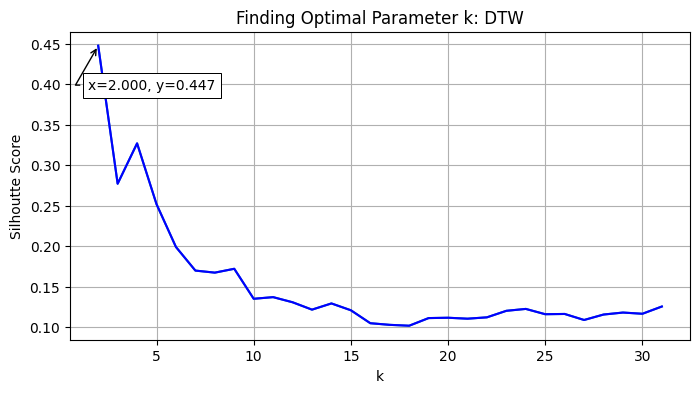

In [ ]:
%%time
sils = pd.DataFrame()
METRIC="dtw"
fig, ax = plt.subplots(figsize=(8, 4))
for k in range(ran):
  km = TimeSeriesKMeans(n_clusters=k+2, metric=METRIC, max_iter=25, max_iter_barycenter=100, random_state=0).fit(df)
  s = silhouette_score(df, km.labels_, metric=METRIC)
  sils = sils.append(pd.DataFrame([k+2,s]).T,ignore_index=True)
plt.plot(sils[0],sils[1])
sils.iloc[np.argmax(sils[1])][0]

ax.plot(sils[0],sils[1],c='b',ls='-',fillstyle='none')
annot_max(sils[0],sils[1],ax)
plt.grid()
plt.title('Finding Optimal Parameter k: DTW')
plt.xlabel("k")
plt.ylabel("Silhoutte Score")

<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

CPU times: user 37min 32s, sys: 11.6 s, total: 37min 44s
Wall time: 21min 24s


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Text(0, 0.5, 'Silhoutte Score')

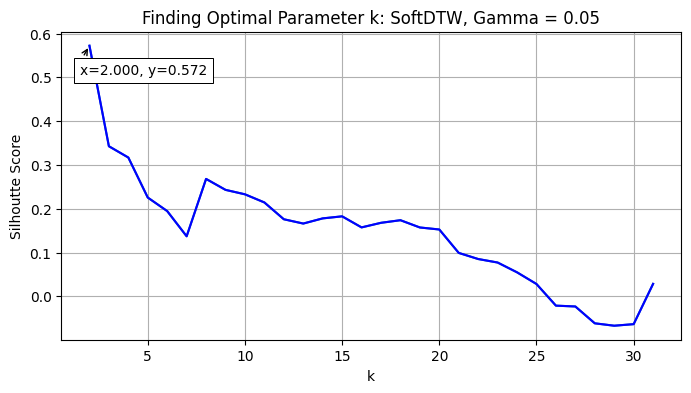

In [ ]:
%%time
sils = pd.DataFrame()
METRIC="softdtw"
fig, ax = plt.subplots(figsize=(8, 4))
for k in range(ran):
  km = TimeSeriesKMeans(n_clusters=k+2, metric=METRIC, max_iter=25, max_iter_barycenter=100, metric_params={"gamma": .05}, random_state=0).fit(df)
  s = silhouette_score(df, km.labels_, metric=METRIC)
  sils = sils.append(pd.DataFrame([k+2,s]).T,ignore_index=True)
plt.plot(sils[0],sils[1])
sils.iloc[np.argmax(sils[1])][0]

ax.plot(sils[0],sils[1],c='b',ls='-',fillstyle='none')
annot_max(sils[0],sils[1],ax)
plt.grid()
plt.title('Finding Optimal Parameter k: SoftDTW, Gamma = 0.05')
plt.xlabel("k")
plt.ylabel("Silhoutte Score")

<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

CPU times: user 35min 6s, sys: 10.9 s, total: 35min 17s
Wall time: 20min 1s


<timed exec>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


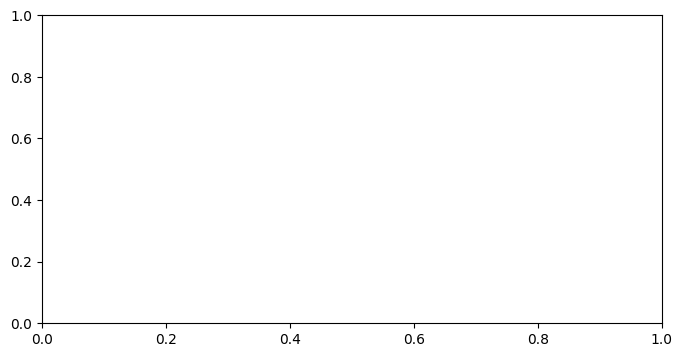

In [ ]:
%%time
sils = pd.DataFrame()
METRIC="softdtw"
fig, ax = plt.subplots(figsize=(8, 4))
for k in range(ran):
  km = TimeSeriesKMeans(n_clusters=k+2, metric=METRIC, max_iter=25, max_iter_barycenter=100, metric_params={"gamma": .2}, random_state=0).fit(df)
  s = silhouette_score(df, km.labels_, metric=METRIC)
  sils = sils.append(pd.DataFrame([k+2,s]).T,ignore_index=True)



Text(0, 0.5, 'Silhoutte Score')

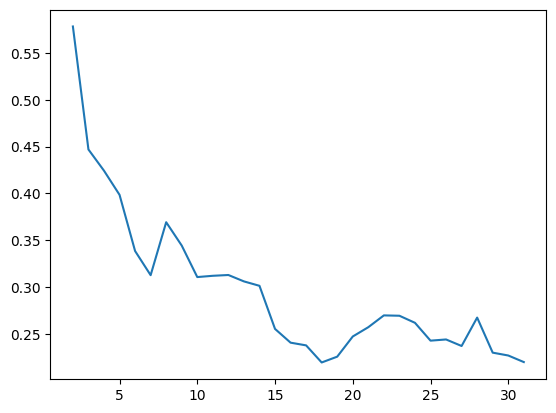

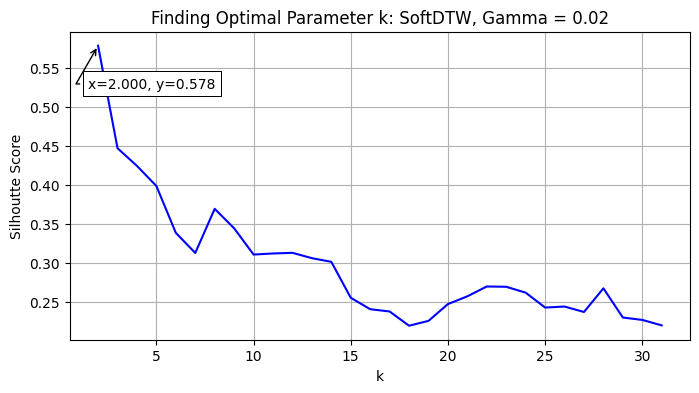

In [ ]:

plt.plot(sils[0],sils[1])
sils.iloc[np.argmax(sils[1])][0]
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(sils[0],sils[1],c='b',ls='-',fillstyle='none')
annot_max(sils[0],sils[1],ax)
plt.grid()
plt.title('Finding Optimal Parameter k: SoftDTW, Gamma = 0.02')
plt.xlabel("k")
plt.ylabel("Silhoutte Score")